In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# 02 August 2024

# Plot Figure 3 for Whillans Catalog Paper
# Events on top of tides

# Imports
import datetime

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import scipy

import pyTMD.io
import pyTMD.time
import timescale
from astropy.timeseries import LombScargle

In [2]:
# Load slip times based on second derivative
ev_data = {"event": [], "trace_time": []}
df = pd.read_csv("AllEventStartTimes.txt", sep="\t")
ev_data["ev_time"] = df["EventStartTime"]

In [3]:
# Try no data from txt file
no_data = {"interval": [], "starts": [], "ends": []}
df = pd.read_csv("no_data.txt", sep="\t")
no_data["starts"] = df["start"]
no_data["ends"] = df["end"]
diff = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    - datetime.datetime.strptime(y, "%Y-%m-%d %H:%M:%S")
    for x, y in zip(no_data["ends"], no_data["starts"])
]
no_data["interval"] = diff
print(no_data)

{'interval': [datetime.timedelta(days=335, seconds=31020), datetime.timedelta(seconds=300), datetime.timedelta(seconds=3825), datetime.timedelta(seconds=360), datetime.timedelta(seconds=390), datetime.timedelta(seconds=390), datetime.timedelta(seconds=390), datetime.timedelta(seconds=360), datetime.timedelta(seconds=360), datetime.timedelta(seconds=360), datetime.timedelta(seconds=360), datetime.timedelta(seconds=390), datetime.timedelta(seconds=390), datetime.timedelta(seconds=390), datetime.timedelta(seconds=390), datetime.timedelta(seconds=390), datetime.timedelta(days=1, seconds=4140), datetime.timedelta(seconds=15810), datetime.timedelta(seconds=29040), datetime.timedelta(seconds=11490), datetime.timedelta(days=2, seconds=79500), datetime.timedelta(seconds=7800), datetime.timedelta(seconds=6300), datetime.timedelta(days=2, seconds=2190), datetime.timedelta(seconds=2070), datetime.timedelta(seconds=10770), datetime.timedelta(seconds=2280), datetime.timedelta(seconds=4440), datetime

In [4]:
print(no_data["starts"][1])

2007-12-14 03:06:15


In [5]:
# Calculate time since last events
time_since_last_ev = [
    datetime.timedelta(seconds=1000000)
]  # Set large for first event because prior event time unknown
for i, event in enumerate(ev_data["ev_time"]):
    if i > 0:
        diff = datetime.datetime.strptime(
            ev_data["ev_time"][i], "%Y-%m-%d %H:%M:%S"
        ) - datetime.datetime.strptime(ev_data["ev_time"][i - 1], "%Y-%m-%d %H:%M:%S")
        time_since_last_ev.append(diff)
ev_data["time_since_last_ev"] = time_since_last_ev
print([(a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]])

[277.77777777777777, 12.341666666666667, 11.929166666666667, 15.05, 12.179166666666667, 13.2625, 26.85, 10.0625, 13.675, 25.391666666666666, 9.591666666666667, 15.9375, 6.925, 15.4875, 9.683333333333334, 15.254166666666666, 24.370833333333334, 11.4625, 14.045833333333333, 25.9875, 21.479166666666668, 13.55, 10.816666666666666, 21.508333333333333, 27.6625, 11.666666666666666, 10.75, 16.166666666666668, 7.579166666666667, 16.770833333333332, 7.583333333333333, 19.333333333333332, 7.525, 17.179166666666667, 7.425, 17.7, 7.558333333333334, 17.145833333333332, 7.866666666666666, 16.475, 7.945833333333334, 16.208333333333332, 8.5875, 15.0125, 9.975, 16.508333333333333, 12.629166666666666, 10.933333333333334, 23.5625, 15.266666666666667, 8.654166666666667, 16.3625, 9.241666666666667, 15.483333333333333, 9.5625, 15.1375, 9.845833333333333, 15.383333333333333, 9.458333333333334, 15.770833333333334, 10.183333333333334, 14.833333333333334, 25.241666666666667, 8.695833333333333, 14.970833333333333

In [6]:
def tides_mm(dates, lat, lon):
    """
    Calcs tides at times for 1 location lat,lon
    times must be in datetime format
    lat, lon floats

    Returns tides in cm
    """
    years = np.array([date.year for date in dates])
    months = np.array([date.month for date in dates])
    days = np.array([date.day for date in dates])
    hours = np.array([date.hour for date in dates])
    minutes = np.array([date.minute for date in dates])

    dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
    mod = "CATS2008-v2023"
    model = pyTMD.io.model(dir, format="netcdf").elevation(mod)

    # Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
    tide_time = timescale.time.convert_calendar_dates(
        year=years, month=months, day=days, hour=hours, minute=minutes
    )
    print(model.format)
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file,
        model.model_file,
        model.projection,
        type=model.type,
        grid=model.format,
    )
    constituents.pop("mf")
    constituents.pop("m2")
    constituents.pop("s2")
    constituents.pop("n2")
    constituents.pop("k2")
    constituents.pop("o1")
    constituents.pop("p1")
    constituents.pop("q1")
    constituents.pop("k1")
    print(constituents)
    c = constituents.fields

    DELTAT = np.zeros_like(tide_time)
    amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
        np.atleast_1d(lon),
        np.atleast_1d(lat),
        constituents,
        model.projection,
        type=model.type,
        method="spline",
        extrapolate=True,
    )

    # calculate complex phase in radians for Euler's
    cph = -1j * ph * np.pi / 180.0
    # calculate constituent oscillation
    hc = amp * np.exp(cph)
    # predict tidal elevations at time 1 and infer minor corrections
    TIDE = pyTMD.predict.time_series(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    # MINOR = pyTMD.predict.infer_minor(tide_time, hc, c,
    #    deltat=DELTAT, corrections=model.format)
    # TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0

    return TIDE.data

In [7]:
def tides(dates, lat, lon):
    """
    Calcs tides at times for 1 location lat,lon
    times must be in datetime format
    lat, lon floats

    Returns tides in cm
    """
    years = np.array([date.year for date in dates])
    months = np.array([date.month for date in dates])
    days = np.array([date.day for date in dates])
    hours = np.array([date.hour for date in dates])
    minutes = np.array([date.minute for date in dates])

    dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
    mod = "CATS2008-v2023"
    model = pyTMD.io.model(dir, format="netcdf").elevation(mod)

    # Calcluate date since Jan 1, 1992 [The format pyTMD wants it in]
    tide_time = timescale.time.convert_calendar_dates(
        year=years, month=months, day=days, hour=hours, minute=minutes
    )
    print(model.format)
    constituents = pyTMD.io.OTIS.read_constants(
        model.grid_file,
        model.model_file,
        model.projection,
        type=model.type,
        grid=model.format,
    )
    print(constituents)
    c = constituents.fields

    DELTAT = np.zeros_like(tide_time)
    amp, ph, D = pyTMD.io.OTIS.interpolate_constants(
        np.atleast_1d(lon),
        np.atleast_1d(lat),
        constituents,
        model.projection,
        type=model.type,
        method="spline",
        extrapolate=True,
    )

    # calculate complex phase in radians for Euler's
    cph = -1j * ph * np.pi / 180.0
    # calculate constituent oscillation
    hc = amp * np.exp(cph)
    # predict tidal elevations at time 1 and infer minor corrections
    TIDE = pyTMD.predict.time_series(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    MINOR = pyTMD.predict.infer_minor(
        tide_time, hc, c, deltat=DELTAT, corrections=model.format
    )
    TIDE.data[:] += MINOR.data[:]
    # convert to centimeters
    TIDE.data[:] *= 100.0

    return TIDE.data

In [8]:
# Tide time series at gz05
spacing = 4  # Minutes
dates_timeseries = []
initial_time = datetime.datetime.strptime("2007-12-01 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(24 * 365 * 11 * 15):
    dates_timeseries.append(initial_time + datetime.timedelta(minutes=spacing * i))

lats = [-84.2986]
lons = [-164.5206]
places = ["gz05"]


for lat, lon, place in zip(lats, lons, places):
    # ev_data[f'tides{place}'] = tides_mm(dates_timeseries, lat, lon)
    ev_data[f"tides{place}"] = tides(dates_timeseries, lat, lon)

TMD3
pyTMD.constituents
    constituents: m2, s2, n2, k2, k1, o1, p1, q1, mf, mm


In [9]:
# Tides at event times
times_to_calculate_tide = ev_data["ev_time"]

dates = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in times_to_calculate_tide
]

lats = [-84.2986]
lons = [-164.5206]
places = ["gz05"]


for lat, lon, place in zip(lats, lons, places):
    # ev_data[f'tide_event_time_{place}'] = tides_mm(dates, lat, lon)
    ev_data[f"tide_event_time_{place}"] = tides(dates, lat, lon)

TMD3
pyTMD.constituents
    constituents: m2, s2, n2, k2, k1, o1, p1, q1, mf, mm


In [10]:
# Calculate distance between event and nearest low and high tides
def dists(ev_data, place):
    # Calculate tidal maxima and minima for comparison

    # https://stackoverflow.com/questions/4624970/finding-local-maxima-minima-with-numpy-in-a-1d-numpy-array

    # Get as indices
    pks = scipy.signal.find_peaks(ev_data[f"tides{place}"], distance=60 / spacing * 3)[
        0
    ]  # Require 5 hrs between peaks
    vlys = scipy.signal.find_peaks(
        -1 * ev_data[f"tides{place}"], distance=60 / spacing * 3
    )[0]  # Require 5 hrs between valleys

    # Also save as times
    pk_times = [dates_timeseries[pk] for pk in pks]
    vly_times = [dates_timeseries[vly] for vly in vlys]

    # Find skipped low tide events (No event within +- 7 hrs of vly)
    skipped_lows = []
    events = [
        datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        for event in ev_data["ev_time"]
    ]
    for i, vly in enumerate(vlys):
        valley = dates_timeseries[vly]
        closest_event = min(events, key=lambda d: abs(d - valley))
        skipped = -1
        if abs(closest_event - valley) > datetime.timedelta(hours=6):
            skipped = 1
        skipped_lows.append(skipped)

    skipped_highs = []
    events = [
        datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        for event in ev_data["ev_time"]
    ]
    for i, pk in enumerate(pks):
        peak = dates_timeseries[pk]
        closest_event = min(events, key=lambda d: abs(d - peak))
        skipped = -1
        if abs(closest_event - peak) > datetime.timedelta(hours=6):
            skipped = 1
        skipped_highs.append(skipped)

    vly_date = [dates_timeseries[vly] for vly in vlys]
    vly_tide = [ev_data[f"tides{place}"][vly] for vly in vlys]

    pk_date = [dates_timeseries[pk] for pk in pks]
    pk_tide = [ev_data[f"tides{place}"][pk] for pk in pks]

    dist_to_highs = []
    dist_to_lows = []
    closest_highs = []
    closest_lows = []
    high_closers = []
    ht_to_highs = []
    ht_to_lows = []
    high_ht_closers = []
    for i, event in enumerate(ev_data["ev_time"]):
        event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        closest_high = min(pk_times, key=lambda d: abs(d - event))
        dist_to_high = event - closest_high
        closest_low = min(vly_times, key=lambda d: abs(d - event))

        ht_to_high = (
            ev_data[f"tide_event_time_{place}"][i]
            - ev_data[f"tides{place}"][pks[pk_times.index(closest_high)]]
        )
        ht_to_low = (
            ev_data[f"tide_event_time_{place}"][i]
            - ev_data[f"tides{place}"][vlys[vly_times.index(closest_low)]]
        )
        ht_to_highs.append(ht_to_high)
        ht_to_lows.append(ht_to_low)

        dist_to_low = event - closest_low
        dist_to_highs.append(dist_to_high)
        dist_to_lows.append(dist_to_low)
        closest_highs.append(closest_high)
        closest_lows.append(closest_low)

        if abs(dist_to_high) < abs(dist_to_low):
            high_closer = 1
        else:
            high_closer = 0
        high_closers.append(high_closer)

        if abs(ht_to_high) < abs(ht_to_low):
            high_closer = 1
        else:
            high_closer = 0
        high_ht_closers.append(high_closer)

    dist_dict = {
        "dist_to_highs": dist_to_highs,
        "dist_to_lows": dist_to_lows,
        "closest_highs": closest_highs,
        "closest_lows": closest_lows,
        "high_closers": high_closers,
        "ht_to_highs": ht_to_highs,
        "ht_to_lows": ht_to_lows,
        "high_ht_closers": high_ht_closers,
        "vly_date": vly_date,
        "vly_tide": vly_tide,
        "pk_date": pk_date,
        "pk_tide": pk_tide,
    }
    return dist_dict

In [11]:
dist_gz05 = dists(ev_data, "gz05")
dist_arr = [dist_gz05]

In [12]:
print(dist_gz05["vly_date"])
print(dist_gz05["pk_date"])
spacing = 1  # Day
dates = []
initial_time = datetime.datetime.strptime("2010-12-12 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(365 * 11):
    dates.append(initial_time + datetime.timedelta(days=spacing * i))

[datetime.datetime(2007, 12, 1, 6, 56), datetime.datetime(2007, 12, 1, 21, 32), datetime.datetime(2007, 12, 2, 7, 56), datetime.datetime(2007, 12, 2, 21, 56), datetime.datetime(2007, 12, 3, 8, 52), datetime.datetime(2007, 12, 3, 22, 24), datetime.datetime(2007, 12, 4, 9, 40), datetime.datetime(2007, 12, 4, 22, 48), datetime.datetime(2007, 12, 5, 10, 32), datetime.datetime(2007, 12, 5, 23, 8), datetime.datetime(2007, 12, 6, 11, 32), datetime.datetime(2007, 12, 6, 23, 32), datetime.datetime(2007, 12, 7, 23, 52), datetime.datetime(2007, 12, 9, 0, 24), datetime.datetime(2007, 12, 10, 0, 56), datetime.datetime(2007, 12, 11, 1, 36), datetime.datetime(2007, 12, 12, 2, 16), datetime.datetime(2007, 12, 13, 2, 52), datetime.datetime(2007, 12, 14, 3, 12), datetime.datetime(2007, 12, 15, 2, 40), datetime.datetime(2007, 12, 16, 2, 0), datetime.datetime(2007, 12, 17, 1, 40), datetime.datetime(2007, 12, 18, 0, 56), datetime.datetime(2007, 12, 18, 22, 28), datetime.datetime(2007, 12, 19, 21, 24), date

In [1]:
# There is a better way to do this because the list is sorted --> Now uses bisect!
import bisect

SEC_IN_HR = 3600
fig, ax = plt.subplots(figsize=[10, 15])
y_offset = 0
for i in range(len(dates[:182])):
    if i > 1:
        st_date = dates[i - 1]
        end_date = dates[i]
        lower = bisect.bisect_right(dist_gz05["vly_date"], st_date)
        upper = bisect.bisect_left(dist_gz05["vly_date"], end_date)
        to_plot = dist_gz05["vly_date"][lower:upper]

        to_plot = [
            datetime.timedelta(
                hours=x.time().hour, minutes=x.time().minute, seconds=x.time().second
            ).total_seconds()
            / SEC_IN_HR
            for x in to_plot
        ]
        y_val = y_offset * np.ones_like(to_plot)
        ax.scatter(to_plot, y_val, color="red")

        lower = bisect.bisect_right(dist_gz05["pk_date"], st_date)
        upper = bisect.bisect_left(dist_gz05["pk_date"], end_date)
        to_plot = dist_gz05["pk_date"][lower:upper]

        to_plot = [
            datetime.timedelta(
                hours=x.time().hour, minutes=x.time().minute, seconds=x.time().second
            ).total_seconds()
            / SEC_IN_HR
            for x in to_plot
        ]
        y_val = y_offset * np.ones_like(to_plot)
        ax.scatter(to_plot, y_val, color="blue")

        y_offset -= 1

ax.scatter(0, 0, color="red", label="Low Tide")
ax.scatter(0, 0, color="blue", label="High Tide")

ax.legend()
ax.set_xlabel("Time [hr]", size=22)
ax.set_ylabel("Days since 12 Decemeber 2010", size=22)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

NameError: name 'plt' is not defined

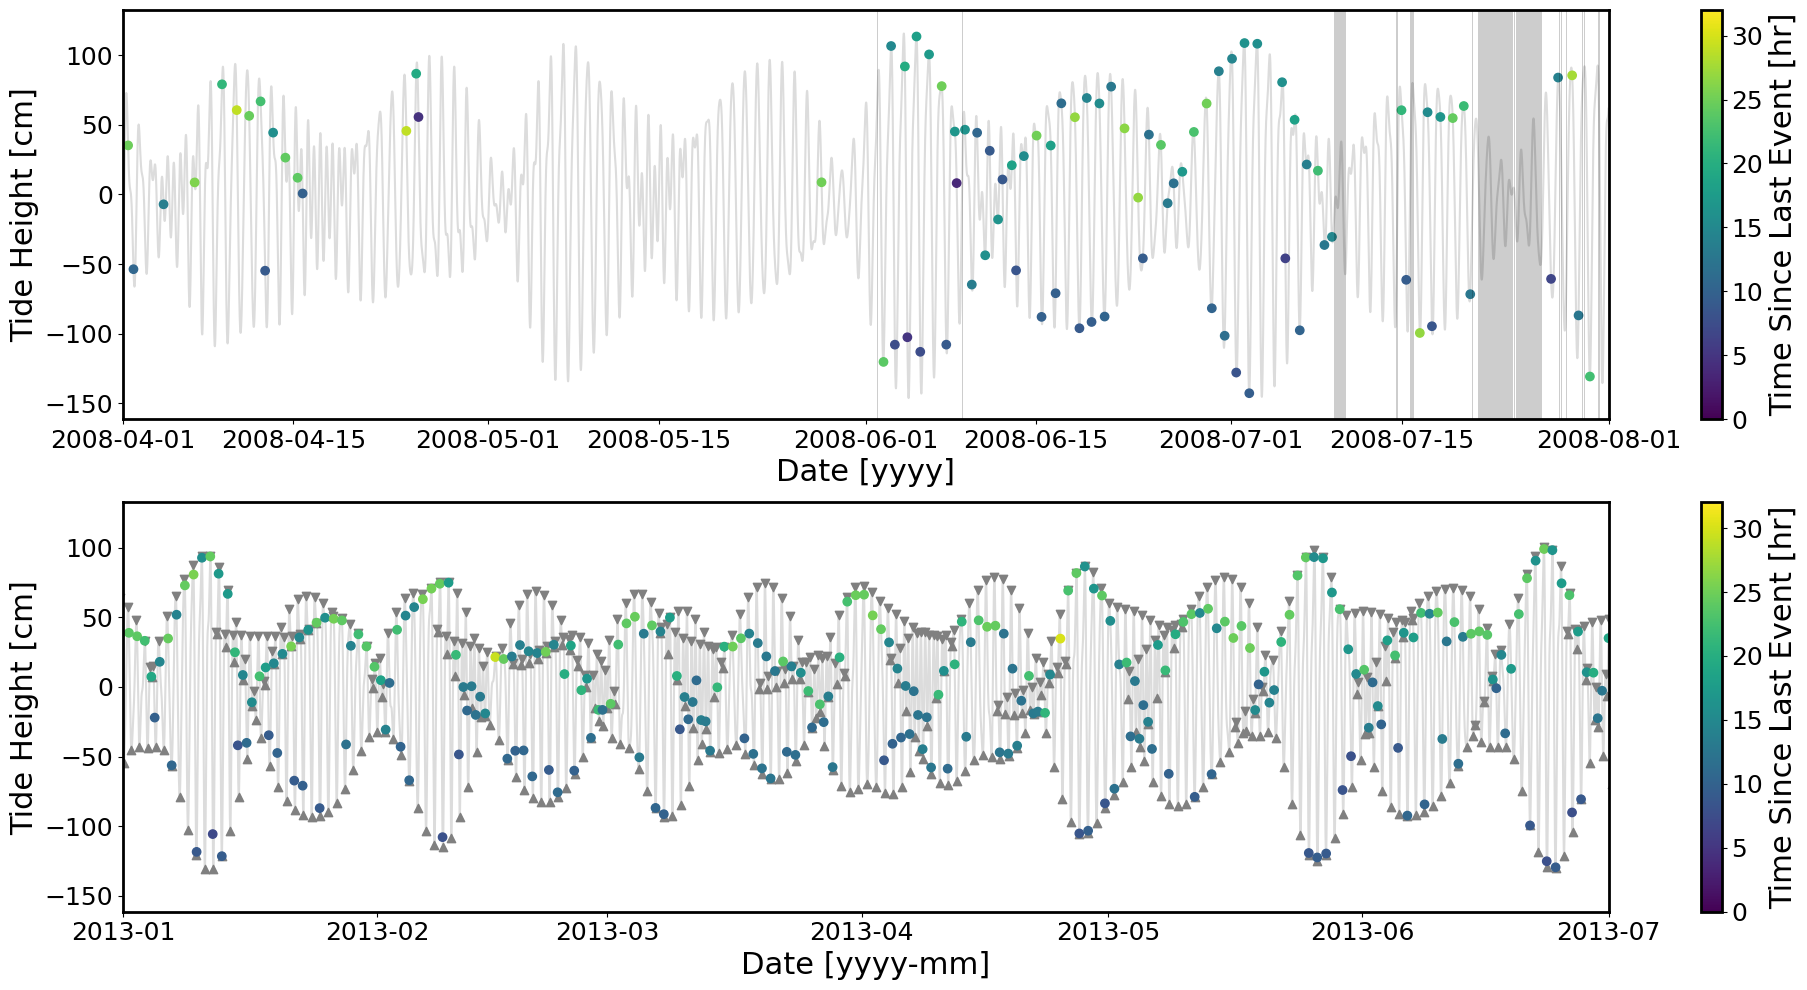

In [19]:
# Plot tides to see trends with diurnal tides
def subplot(ax, place, dist, st, ed, triangles=False):
    """Subplot for Figure 3. Plots tides and events colored by time since last event

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        Axis to plot on
    place : str
        Place tides are modeled at
    dist : dict
        Dict of high and low tides
    st : datetime.datetime
        Start time of panel
    ed : datetime.datetime
        End time of panel;
    triangles : bool, optional
        Flag to plot low and high tide triangles. Default is False.
    """
    ax.plot(dates_timeseries, ev_data[f"tides{place}"], zorder=0, color="gainsboro")
    if triangles:
        ax.scatter(dist["pk_date"], dist["pk_tide"], zorder=0, color="gray", marker="v")
        ax.scatter(
            dist["vly_date"], dist["vly_tide"], zorder=0, color="gray", marker="^"
        )
    hr_since_last_ev = [
        (a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]
    ]
    masked_hr = np.ma.masked_where(np.array(hr_since_last_ev) > 32, ev_data["ev_time"])
    cax = ax.scatter(
        masked_hr,
        ev_data[f"tide_event_time_{place}"],
        c=hr_since_last_ev,
        zorder=2,
        cmap="viridis",
        vmin=0,
        vmax=32,
    )
    cbar = plt.colorbar(cax)
    cbar.set_label("Time Since Last Event [hr]", size=22)
    cbar.ax.tick_params(labelsize=18)
    ax.set_xlim(st, ed)
    # ax.set_xlim(datetime.datetime(2012,12,8),datetime.datetime(2013,5,20))
    ax.set_xlabel("Date [yyyy]", size=22)
    if triangles:
        ax.set_xlabel("Date [yyyy-mm]", size=22)
    ax.set_ylabel("Tide Height [cm]", size=22)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)

    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.1, zorder=3
        )
        ax1.add_patch(rect)

    # ax.set_title(f'{place} Tide Reference',size=20)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[20, 10])
st = datetime.datetime(2007, 12, 1)
ed = datetime.datetime(2019, 6, 17)

st = datetime.datetime(2008, 4, 1)
ed = datetime.datetime(2008, 8, 1)

subplot(ax1, "gz05", dist_gz05, st, ed, triangles=False)
st = datetime.datetime(2013, 1, 1)
ed = datetime.datetime(2013, 7, 1)

# st = datetime.datetime(2007,11,1)
# ed = datetime.datetime(2009,1,1)

subplot(ax2, "gz05", dist_gz05, st, ed, triangles=True)
fig.tight_layout()

In [21]:
print(no_data["starts"][:20])
print(no_data["interval"][:20])

0     2007-01-01 00:00:00
1     2007-12-14 03:06:15
2     2007-12-14 04:58:00
3     2008-04-16 02:22:00
4     2008-05-30 23:17:00
5     2008-05-31 23:13:00
6     2008-06-01 23:09:00
7     2008-06-02 23:05:00
8     2008-06-03 23:01:00
9     2008-06-04 22:57:00
10    2008-06-05 22:53:00
11    2008-06-07 22:44:30
12    2008-06-08 22:40:30
13    2008-06-09 22:36:30
14    2008-06-10 22:32:30
15    2008-06-16 22:08:00
16    2008-07-09 10:20:00
17    2008-07-14 12:20:30
18    2008-07-15 17:19:30
19    2008-07-20 17:55:00
Name: start, dtype: object
[datetime.timedelta(days=335, seconds=31020), datetime.timedelta(seconds=300), datetime.timedelta(seconds=3825), datetime.timedelta(seconds=360), datetime.timedelta(seconds=390), datetime.timedelta(seconds=390), datetime.timedelta(seconds=390), datetime.timedelta(seconds=360), datetime.timedelta(seconds=360), datetime.timedelta(seconds=360), datetime.timedelta(seconds=360), datetime.timedelta(seconds=390), datetime.timedelta(seconds=390), datetime.t

In [22]:
# Find time since last event for all skipped low tides
time_since_last_event_low_pk = []
time_to_next_event_low_pk = []

events = np.ma.masked_where(
    np.array(dist_gz05["high_closers"]) == 1, ev_data["ev_time"]
)
events = np.ma.compressed(events)
tide_low = np.ma.masked_where(
    np.array(dist_gz05["high_closers"]) == 1, ev_data["tide_event_time_gz05"]
)
tide_low = np.ma.compressed(tide_low)

for i, valley in enumerate(dist_gz05["vly_date"]):
    closest_event = min(
        events,
        key=lambda d: abs(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") - valley),
    )
    if datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") > valley:
        closest_event = events[np.where(events == closest_event)[0] - 1][0]
    time_since_last_event_low_pk.append(
        valley - datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S")
    )

    closest_event = min(
        events,
        key=lambda d: abs(datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") - valley),
    )
    if datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") < valley:
        try:
            closest_event = events[np.where(events == closest_event)[0] + 1][0]
        except IndexError:
            pass
    time_to_next_event_low_pk.append(
        datetime.datetime.strptime(closest_event, "%Y-%m-%d %H:%M:%S") - valley
    )

In [23]:
def rolling_average(
    window,
    slide_len,
    time_since_last_event_low_pk,
    time_to_next_event_low_pk,
    dist_gz05,
    ev_data,
    no_data,
):
    """Rolling average of slip events.

    Parameters
    ----------
    window : int
        Days to average over
    slide_len : int
        Days to slide window
    time_since_last_event_low_pk : list
        Times since last event
    time_to_next_event_low_pk : list
        Time to next event
    dist_gz05 : dict
        Dict of high and low tides
    ev_data : dict
        Dict of event data
    no_data : dict
        Dict of no data times
    """
    # Compute rolling average of skipped low slips

    time_since_low_hr = [a.total_seconds() / 3600 for a in time_since_last_event_low_pk]
    time_to_low_hr = [a.total_seconds() / 3600 for a in time_to_next_event_low_pk]

    mask = []
    for ts, tt in zip(time_since_low_hr, time_to_low_hr):
        if ts < 6 or tt < 6:
            mask.append(1)
        else:
            mask.append(0)

    masked_low_skips = np.ma.masked_where(mask, dist_gz05["vly_date"])
    masked_low_skips = np.ma.compressed(masked_low_skips)

    dates_timeseries_avg = []
    initial_time = datetime.datetime.strptime(
        "2007-12-01 00:00:00", "%Y-%m-%d %H:%M:%S"
    )

    time_to_append = window  # Days
    slide = slide_len  # Days

    # assert time_to_append % slide == 0
    interval = int(time_to_append // slide)  # MUST BE AN INTEGER

    rng = int(11 * 365 // slide)  # Range of times
    for i in range(rng):
        dates_timeseries_avg.append(initial_time + datetime.timedelta(days=slide * i))

    skips = []
    skip_starts = []
    skip_ends = []
    skip_middles = []
    tot_slips = []
    spacings = []

    for i, date in enumerate(dates_timeseries_avg):
        if i > interval:
            interval_start = dates_timeseries_avg[i - interval]
            interval_end = date

            # print(interval_start,interval_end)
            last_ev = datetime.datetime.strptime(
                ev_data["ev_time"].iloc[-1], "%Y-%m-%d %H:%M:%S"
            )
            first_ev = datetime.datetime.strptime(
                ev_data["ev_time"].iloc[0], "%Y-%m-%d %H:%M:%S"
            )
            stop = False
            for start, end in zip(no_data["starts"], no_data["ends"]):
                start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
                end = datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S")

                # Check that interval does not include gaps in data or start before 1st event or end after last event
                # if (interval_start > start and interval_start < end) or (interval_end > start and interval_end < end) \
                #    or (interval_start < end and interval_end > start) or (interval_start < start and interval_end > start) \
                #        or interval_start < first_ev \
                #        or interval_end > last_ev:
                #    stop = True

                if (
                    (interval_start < end and interval_end > start)
                    or interval_start < first_ev
                    or interval_end > last_ev
                ):
                    stop = True

            if not stop:
                # Number of total events
                slip = 0
                for event in ev_data["ev_time"]:
                    event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
                    if event > interval_start and event < interval_end:
                        slip += 1

                # Number of low skips
                skip = 0
                for date_low in masked_low_skips:
                    if date_low > interval_start and date_low < interval_end:
                        skip += 1

                # Avg Event spacing
                spacing = 0
                counter = 0
                time_since = [
                    (a.days * 24 * 3600 + a.seconds) / 3600
                    for a in ev_data["time_since_last_ev"]
                ]
                for f, event in enumerate(ev_data["ev_time"]):
                    event = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
                    if event > interval_start and event < interval_end:
                        spacing += time_since[f]
                        counter += 1
                try:
                    spacing = spacing / counter
                except ZeroDivisionError:
                    spacing = np.nan
                # Avg Event amplitude

            else:
                skip = np.nan
                slip = np.nan
                spacing = np.nan

            skip_starts.append(interval_start)
            skip_ends.append(interval_end)
            skip_middles.append(interval_start + (interval_end - interval_start) / 2)
            skips.append(skip)
            tot_slips.append(slip)
            spacings.append(spacing)

    return skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings

In [24]:
def annotation(ax, x1, x2, y1, y2, text):
    """Draws an annotated bracket."""
    xs = [x1, x1, x2, x2]
    ys = [y1, y2, y2, y1]
    ax.plot(xs, ys, "k-")
    ax.text((x2 - x1) / 2 + x1, y2 + 0.1, text, ha="center", va="bottom", fontsize=18)

In [25]:
# Plotting function
def plot_rolling_avg_mm(
    window, slide_len, skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings
):
    # Skipped slips by number of slips in xx period

    fig, (ax1, ax3) = plt.subplots(2, figsize=(20, 12))
    ax2 = ax1.twinx()
    (
        ax1.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax1.add_patch(rect)

    ax1.set_xlim(datetime.datetime(2008, 12, 8), datetime.datetime(2019, 5, 20))
    ax1.set_ylim(20, 130)
    ax1.set_ylim(-5, 5)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    ax2.errorbar(skip_middles, tot_slips, xerr=xerr, fmt="o", color="black", zorder=2)
    # ax2.plot(skip_middles, tot_slips, color='blue')

    timestamps = [a.timestamp() for a in skip_middles]

    compressed_tot_slips = np.ma.masked_invalid(tot_slips)
    compressed_timestamps = np.ma.masked_where(
        np.ma.getmask(compressed_tot_slips), timestamps
    )
    compressed_tot_slips = np.ma.compressed(compressed_tot_slips)
    compressed_timestamps = np.ma.compressed(compressed_timestamps)

    coef = np.polyfit(compressed_timestamps, compressed_tot_slips, 1)
    print(coef)
    lst_sqrs_fit = np.poly1d(coef)
    print(lst_sqrs_fit[1])

    datetimes = [datetime.datetime.fromtimestamp(a) for a in compressed_timestamps]
    # ax2.plot(datetimes, lst_sqrs_fit(compressed_timestamps),color='blue',zorder=3)

    # Just a line so manually extract slope
    delta_y = (
        lst_sqrs_fit(compressed_timestamps)[-1] - lst_sqrs_fit(compressed_timestamps)[0]
    )
    delta_x = datetimes[-1] - datetimes[0]

    print(delta_y, delta_x)
    slope = delta_y / delta_x.total_seconds() * 3600 * 24 * 365
    print(slope)  # Slips / year
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    ax1.set_xlabel("Date [yyyy]", size=22)
    ax1.set_ylabel("Tide Height [cm]", size=22)
    ax2.set_ylabel(f"Slips [{window} Day Rolling Avg]", size=22, color="black")
    ax1.xaxis.set_tick_params(labelsize=18)
    ax1.yaxis.set_tick_params(labelsize=18, color="gray")
    ax2.yaxis.set_tick_params(labelsize=18, colors="black")
    # ax2.spines['left'].set_color('red')

    ax4 = ax3.twinx()
    (
        ax3.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax3.add_patch(rect)

    ax3.set_xlim(datetime.datetime(2013, 1, 1), datetime.datetime(2014, 1, 1))
    # ax3.set_xlim(datetime.datetime(2008,12,8),datetime.datetime(2009,7,1))
    ax3.set_ylim(-155, 130)
    ax3.set_ylim(-5, 5)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    ax4.errorbar(skip_middles, tot_slips, xerr=xerr, fmt="o", color="black", zorder=2)

    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    ax4.yaxis.set_label_position("left")
    ax4.yaxis.tick_left()
    ax3.set_xlabel("Date [yyyy-mm]", size=22)
    ax3.set_ylabel("Tide Height [cm]", size=22)
    ax4.set_ylabel(f"Slips [{window} Day Rolling Avg]", size=22, color="black")
    ax3.xaxis.set_tick_params(labelsize=18)
    ax3.yaxis.set_tick_params(labelsize=18, color="gray")
    ax4.yaxis.set_tick_params(labelsize=18, colors="black")

    ssa_time = datetime.timedelta(days=182.63)
    ssa_start = datetime.datetime(2014, 3, 1)
    annotation(ax1, ssa_start, ssa_start + ssa_time, 3.5, 4, "$S_{sa}$")

    mm_time = datetime.timedelta(days=27.55)
    mm_start = datetime.datetime(2013, 5, 1)
    annotation(ax3, mm_start, mm_start + mm_time, 3.5, 4, "$M_{m}$")

    # ax1.set_title(f'{time_to_append} Day Rolling Average',size=22)

    ax1.set_title(f"{window} Day Rolling Average", size=22)
    fig.tight_layout()

In [26]:
# Plotting function
def plot_rolling_avg(
    window, slide_len, skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings
):
    # Skipped slips by number of slips in xx period

    fig, (ax1, ax3) = plt.subplots(2, figsize=(20, 12))
    ax2 = ax1.twinx()
    (
        ax1.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax1.add_patch(rect)

    ax1.set_xlim(datetime.datetime(2007, 12, 1), datetime.datetime(2019, 6, 17))
    ax1.set_ylim(-120, 130)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    ax2.errorbar(skip_middles, tot_slips, xerr=xerr, fmt="o", color="black", zorder=2)
    # ax2.plot(skip_middles, tot_slips, color='blue')

    timestamps = [a.timestamp() for a in skip_middles]

    compressed_tot_slips = np.ma.masked_invalid(tot_slips)
    compressed_timestamps = np.ma.masked_where(
        np.ma.getmask(compressed_tot_slips), timestamps
    )
    compressed_tot_slips = np.ma.compressed(compressed_tot_slips)
    compressed_timestamps = np.ma.compressed(compressed_timestamps)

    coef = np.polyfit(compressed_timestamps, compressed_tot_slips, 1)
    print(coef)
    lst_sqrs_fit = np.poly1d(coef)
    print(lst_sqrs_fit[1])

    datetimes = [datetime.datetime.fromtimestamp(a) for a in compressed_timestamps]
    # ax2.plot(datetimes, lst_sqrs_fit(compressed_timestamps),color='blue',zorder=3)

    # Just a line so manually extract slope
    delta_y = (
        lst_sqrs_fit(compressed_timestamps)[-1] - lst_sqrs_fit(compressed_timestamps)[0]
    )
    delta_x = datetimes[-1] - datetimes[0]

    print(delta_y, delta_x)
    slope = delta_y / delta_x.total_seconds() * 3600 * 24 * 365
    print(slope)  # Slips / year
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    ax1.set_xlabel("Date [yyyy]", size=22)
    ax1.set_ylabel("Tide Height [cm]", size=22)
    ax2.set_ylabel(f"Slips [{window} Day Rolling Avg]", size=22, color="black")
    ax1.xaxis.set_tick_params(labelsize=18)
    ax1.yaxis.set_tick_params(labelsize=18, color="gray")
    ax2.yaxis.set_tick_params(labelsize=18, colors="black")
    # ax2.spines['left'].set_color('red')

    ax4 = ax3.twinx()
    (
        ax3.plot(
            dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4
        ),
    )
    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
        )
        ax3.add_patch(rect)

    ax3.set_xlim(datetime.datetime(2014, 1, 1), datetime.datetime(2015, 6, 1))
    # ax3.set_xlim(datetime.datetime(2008,12,8),datetime.datetime(2009,7,1))
    ax3.set_ylim(-155, 130)

    xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
    ax4.errorbar(skip_middles, tot_slips, xerr=xerr, fmt="o", color="black", zorder=2)

    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    ax4.yaxis.set_label_position("left")
    ax4.yaxis.tick_left()
    ax3.set_xlabel("Date [yyyy-mm]", size=22)
    ax3.set_ylabel("Tide Height [cm]", size=22)
    ax4.set_ylabel(f"Slips [{window} Day Rolling Avg]", size=22, color="black")
    ax3.xaxis.set_tick_params(labelsize=18)
    ax3.yaxis.set_tick_params(labelsize=18, color="gray")
    ax4.yaxis.set_tick_params(labelsize=18, colors="black")

    ssa_time = datetime.timedelta(days=182.63)
    ssa_start = datetime.datetime(2014, 3, 1)
    annotation(ax1, ssa_start, ssa_start + ssa_time, 88, 92, "$S_{sa}$")

    mm_time = datetime.timedelta(days=27.55)
    mm_start = datetime.datetime(2014, 2, 20)
    annotation(ax3, mm_start, mm_start + mm_time, 80, 84, "$M_{m}$")

    # ax1.set_title(f'{time_to_append} Day Rolling Average',size=22)

    ax1.set_title(f"{window} Day Rolling Average", size=22)
    fig.tight_layout()

In [2]:
slide = 1
for window in [3, 27, 45]:
    skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings = rolling_average(
        window,
        slide,
        time_since_last_event_low_pk,
        time_to_next_event_low_pk,
        dist_gz05,
        ev_data,
        no_data,
    )
    plot_rolling_avg(
        window, slide, skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings
    )

NameError: name 'rolling_average' is not defined

In [28]:
slide = 1
rolling_avg_dicts = []
for window in [3, 27, 45]:
    skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings = rolling_average(
        window,
        slide,
        time_since_last_event_low_pk,
        time_to_next_event_low_pk,
        dist_gz05,
        ev_data,
        no_data,
    )
    # Save as dict
    rolling_avg_dict = {
        "skip_starts": skip_starts,
        "skip_ends": skip_ends,
        "skip_middles": skip_middles,
        "skips": skips,
        "tot_slips": tot_slips,
        "spacings": spacings,
    }
    rolling_avg_dicts.append(rolling_avg_dict)

In [29]:
import matplotlib as mpl

viridis = mpl.colormaps["viridis"].resampled(20)
# Add window to rolling avg dict
for i, window in enumerate([3, 27, 45]):
    rolling_avg_dicts[i]["window"] = window

[-3.66655876e-09  9.39518742e+00]
-3.6665587571000794e-09
-1.2700138225433077 4009 days, 0:00:00
-0.11562859696390802
[-3.84353682e-08  9.22406595e+01]
-3.8435368223297245e-08
-13.19360123098022 3973 days, 0:00:00
-1.212097772289902
[-7.13950866e-08  1.64106758e+02]
-7.139508656014821e-08
-24.39655781864137 3955 days, 0:00:00
-2.2515154497608347


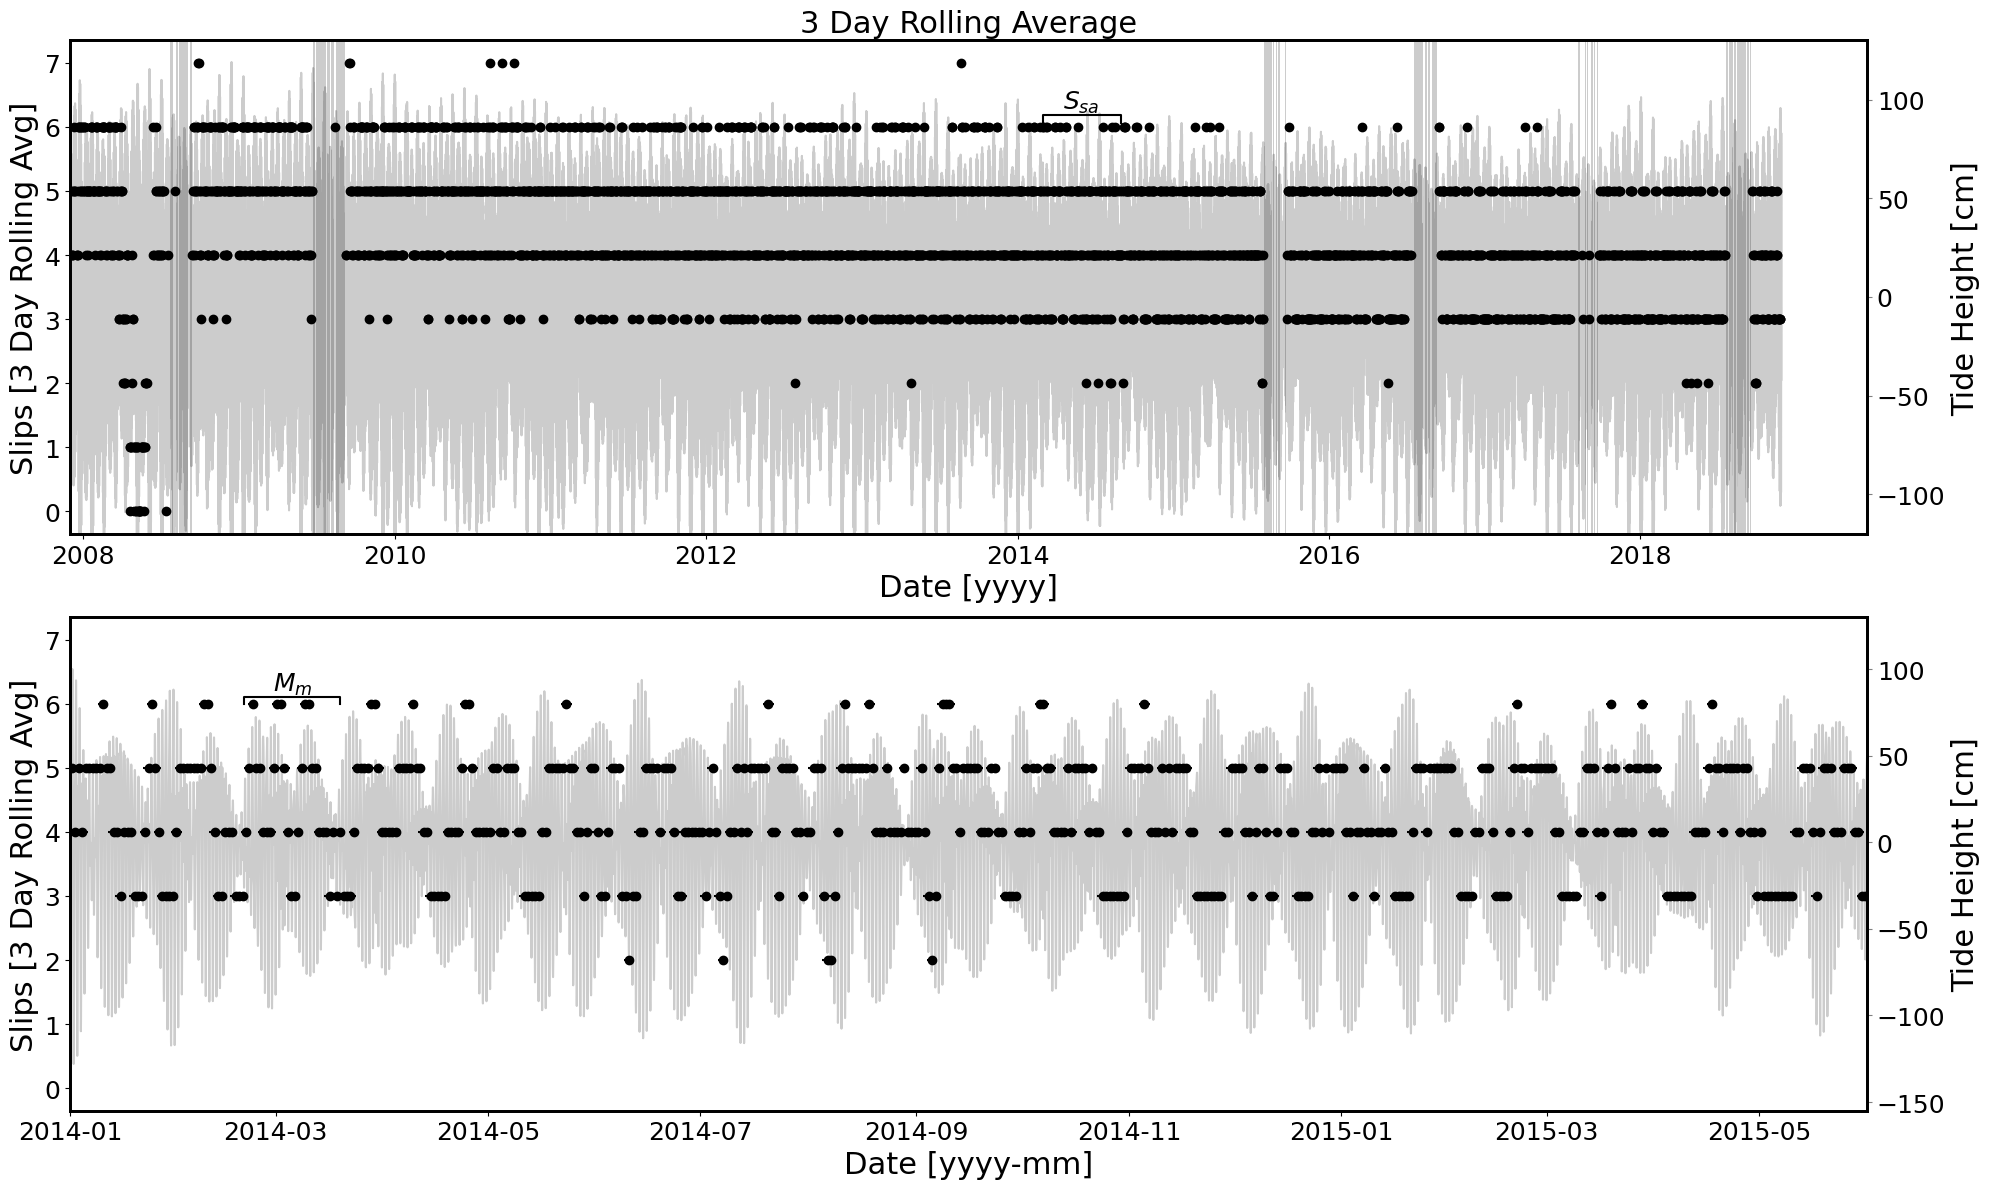

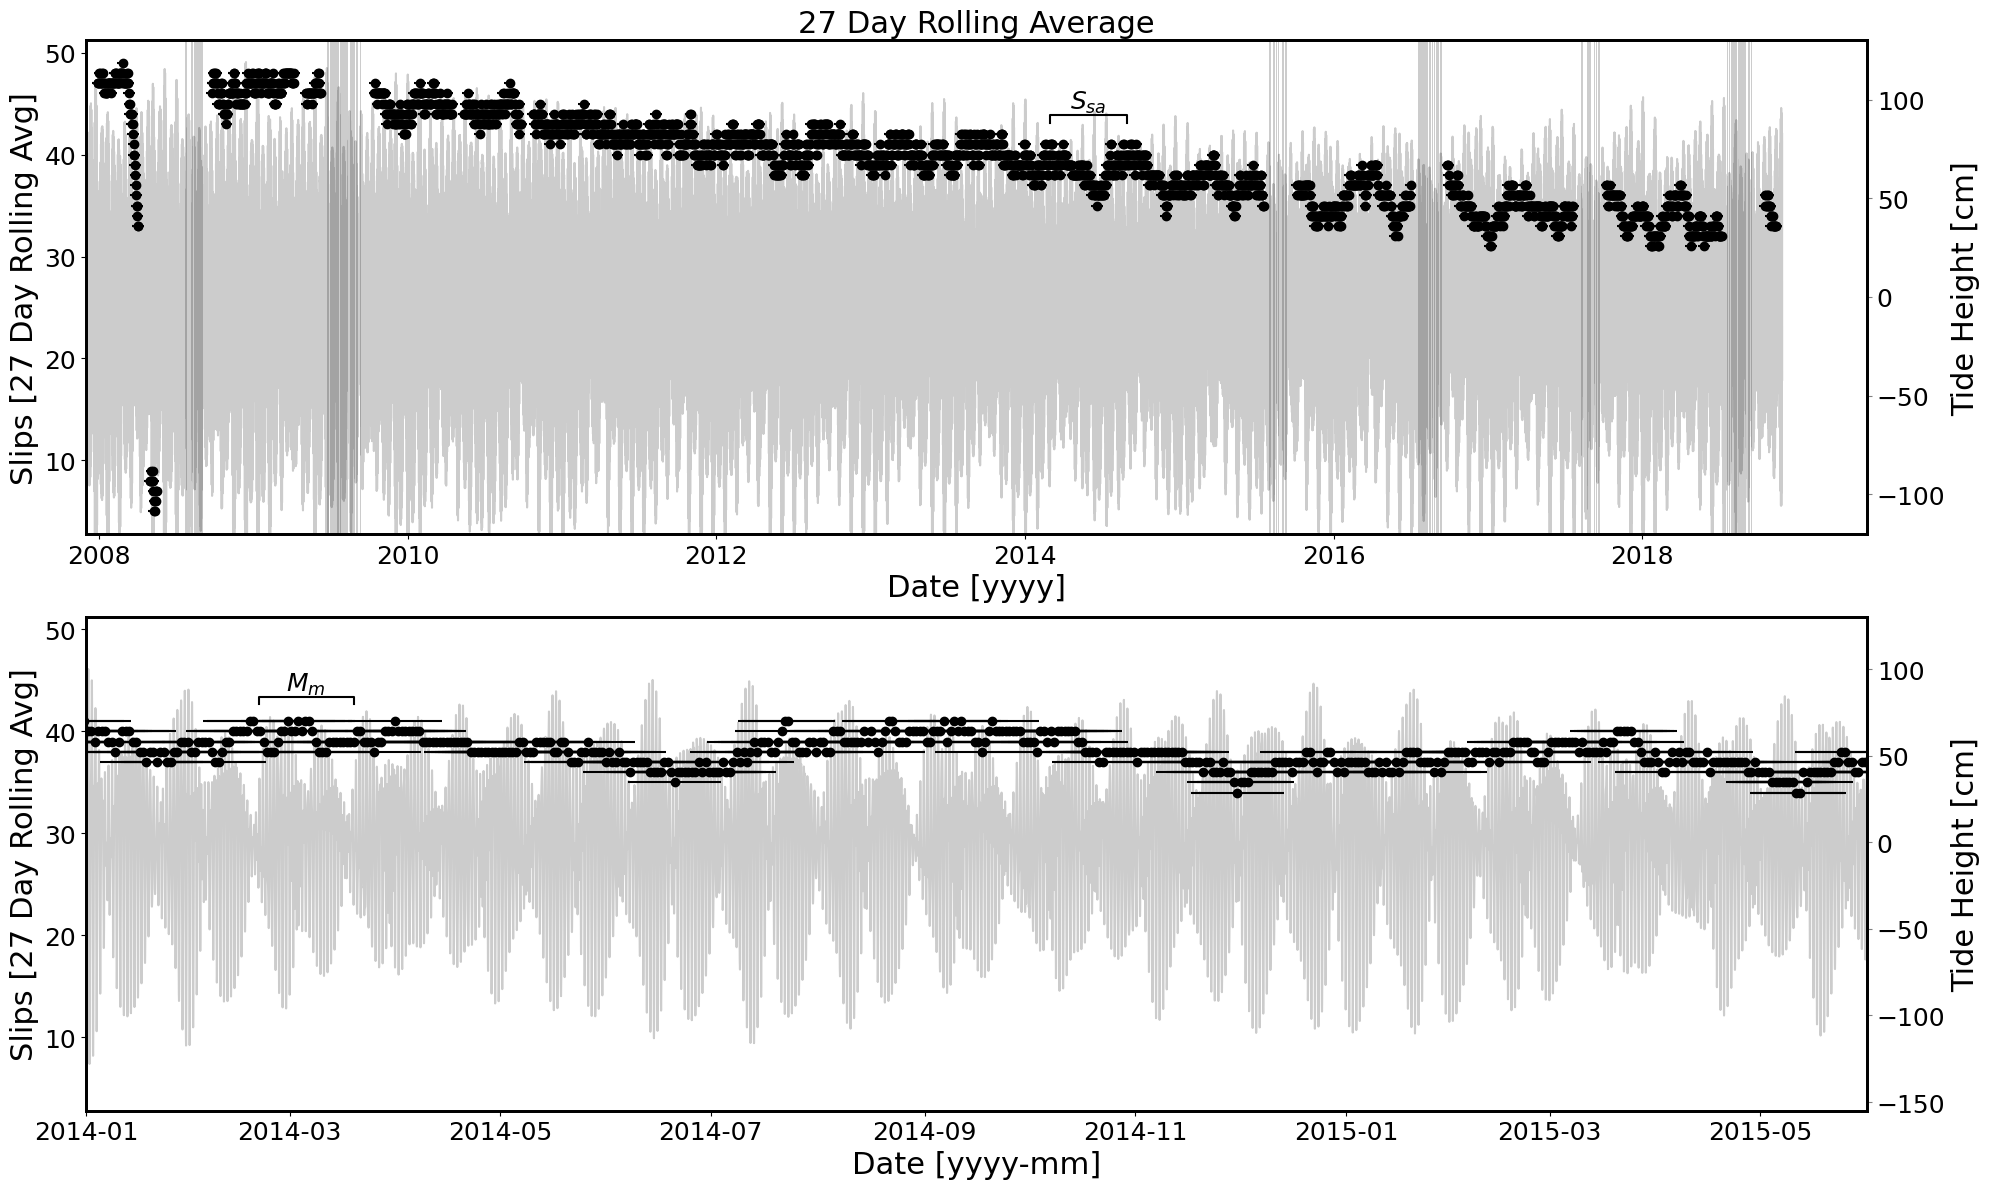

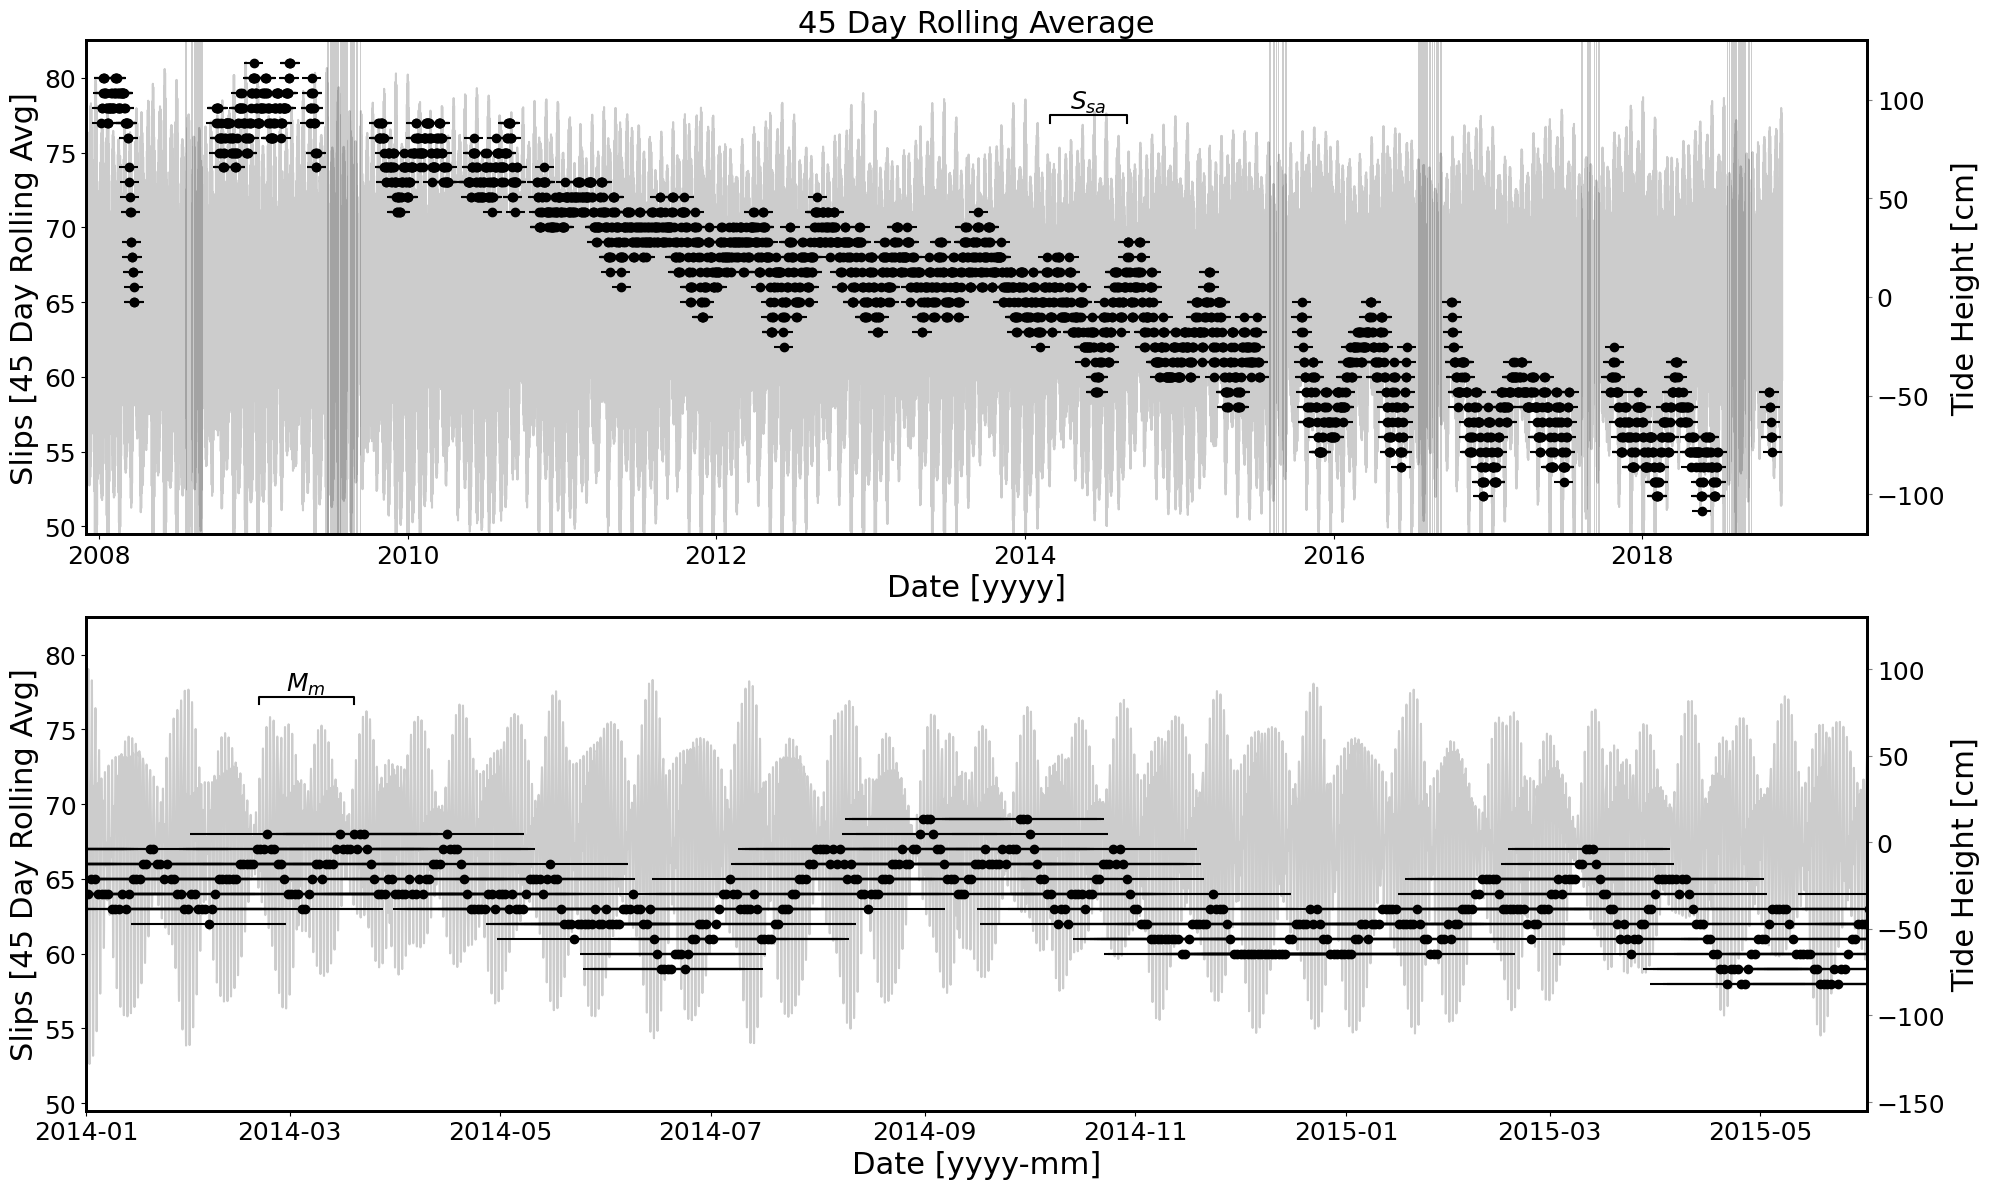

In [30]:
# Plot lomb scargles
slide = 1
for i, rolling_avg_dict in enumerate(rolling_avg_dicts):
    # Unpack dictionary
    skip_starts = rolling_avg_dict["skip_starts"]
    skip_ends = rolling_avg_dict["skip_ends"]
    skip_middles = rolling_avg_dict["skip_middles"]
    skips = rolling_avg_dict["skips"]
    tot_slips = rolling_avg_dict["tot_slips"]
    spacings = rolling_avg_dict["spacings"]
    window = rolling_avg_dict["window"]
    plot_rolling_avg(
        window, slide, skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings
    )

    """
    # LOMB SCARGLE ->
    dates_as_sec = [a.timestamp() for a in skip_middles]
    tot_slips_masked = np.ma.masked_array(tot_slips, mask=np.invert(~np.isnan(tot_slips)))
    dates_as_sec_masked = np.ma.masked_array(dates_as_sec, mask=np.invert(~np.isnan(tot_slips)))
    tot_slips_masked = np.ma.compressed(tot_slips_masked)
    dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
    tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

    # Spectrogram of rolling avg slips using lomb scargle
    frequency, power = LombScargle(dates_as_sec_masked,tot_slips_detrended).autopower()

    pks = scipy.signal.find_peaks(power[:10000],height=0.05)[0]
    fig, ax = plt.subplots(figsize=(9,5))
    #ax.plot(frequency[pks], power[pks], 'ro')
    ax.plot(frequency, power)
    ax.set_title(f'Event {window} Day Rolling Average Lomb-Scargle Periodogram',  fontsize=16)
    ax.set_xlabel("Frequency [Hz]",fontsize=18)
    ax.set_ylabel("Normalized Power",fontsize=18)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlim(0,0.05e-5)  


    SEC_TO_DAY = 3600 * 24
    SEC_TO_HR = 3600
    for pk,pwr in zip(frequency[pks],power[pks]):
        if pk < 0.25e-5:
            print(f'{1/pk/SEC_TO_DAY} Days, Power = {pwr}')
            ax.text(pk + 0.001e-5, pwr, f'{1/pk/SEC_TO_DAY:.2f} Days')
        else:
            print(f'{1/pk/SEC_TO_HR} Hours, Power = {pwr}')
            ax.tect(0.01e-5, 0.1, f'{1/pk/SEC_TO_HR:.2f} Hours')
    """

In [3]:
# Plot all rolling averages on one plot
fig, (ax1, ax3) = plt.subplots(2, figsize=(20, 12))
ax2 = ax1.twinx()
(ax1.plot(dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4),)
for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    rect = plt.Rectangle(
        (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
    )
    ax1.add_patch(rect)

ax1.set_xlim(datetime.datetime(2008, 12, 8), datetime.datetime(2019, 5, 20))
ax1.set_ylim(-155, 130)

ax4 = ax3.twinx()
(ax3.plot(dates_timeseries, ev_data["tidesgz05"], zorder=1, color="gray", alpha=0.4),)
for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
    start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    rect = plt.Rectangle(
        (start, -200), interval, 1000, facecolor="black", alpha=0.2, zorder=3
    )
    ax3.add_patch(rect)

ax3.set_xlim(datetime.datetime(2013, 1, 1), datetime.datetime(2015, 1, 1))
ax3.set_ylim(-155, 130)

colors = np.linspace(0, 1, len(rolling_avg_dicts))
for i, (rolling_avg_dict, color) in enumerate(zip(rolling_avg_dicts, colors)):
    if i < 10:
        clr = viridis(color)
        skip_starts = rolling_avg_dict["skip_starts"]
        skip_ends = rolling_avg_dict["skip_ends"]
        skip_middles = rolling_avg_dict["skip_middles"]
        tot_slips = rolling_avg_dict["tot_slips"]
        window = rolling_avg_dict["window"]
        xerr = [(end - start) // 2 for start, end in zip(skip_starts, skip_ends)]
        ax2.plot(skip_middles, tot_slips, color=clr)
        ax4.plot(skip_middles, tot_slips, color=clr, label=f"{window}")
        # ax2.errorbar(skip_middles, tot_slips,xerr=xerr,fmt='o',color=clr,zorder=2)
        # ax4.errorbar(skip_middles, tot_slips,xerr=xerr,fmt='o',color=clr,zorder=2)

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_left()
ax1.set_xlabel("Date [yyyy]", size=22)
ax1.set_ylabel("Tide Height [cm]", size=22)
ax2.set_ylabel("Slips [Rolling Avg]", size=22, color="black")
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18, color="gray")
ax2.yaxis.set_tick_params(labelsize=18, colors="black")

ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax4.yaxis.set_label_position("left")
ax4.yaxis.tick_left()
ax3.set_xlabel("Date [yyyy-mm]", size=22)
ax3.set_ylabel("Tide Height [cm]", size=22)
ax4.set_ylabel("Slips [Rolling Avg]", size=22, color="black")
ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18, color="gray")
ax4.yaxis.set_tick_params(labelsize=18, colors="black")
ax4.legend()


ssa_time = datetime.timedelta(days=182.63)
ssa_start = datetime.datetime(2014, 3, 1)
annotation(ax1, ssa_start, ssa_start + ssa_time, 88, 92, "$S_{sa}$")

mm_time = datetime.timedelta(days=27.55)
mm_start = datetime.datetime(2014, 2, 20)
annotation(ax3, mm_start, mm_start + mm_time, 80, 84, "$M_{m}$")

NameError: name 'plt' is not defined

In [4]:
# Plot lomb scargles
SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
xlim = 450

slide = 1
for i, rolling_avg_dict in enumerate(rolling_avg_dicts):
    # Unpack dictionary
    skip_starts = rolling_avg_dict["skip_starts"]
    skip_ends = rolling_avg_dict["skip_ends"]
    skip_middles = rolling_avg_dict["skip_middles"]
    skips = rolling_avg_dict["skips"]
    tot_slips = rolling_avg_dict["tot_slips"]
    spacings = rolling_avg_dict["spacings"]
    window = rolling_avg_dict["window"]

    dates_as_sec = [a.timestamp() for a in skip_middles]
    tot_slips_masked = np.ma.masked_array(
        tot_slips, mask=np.invert(~np.isnan(tot_slips))
    )
    dates_as_sec_masked = np.ma.masked_array(
        dates_as_sec, mask=np.invert(~np.isnan(tot_slips))
    )
    tot_slips_masked = np.ma.compressed(tot_slips_masked)
    dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
    tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

    # Spectrogram of rolling avg slips using lomb scargle
    frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()

    pks = scipy.signal.find_peaks(power[:10000], height=0.04)[0]
    fig, ax = plt.subplots(figsize=(9, 7))
    # ax.plot(frequency[pks], power[pks], 'ro')
    period = 1 / frequency / SEC_TO_DAY  # Days
    ax.plot(period, power)
    ax.set_title(
        f"Event {window} Day Rolling Average Lomb-Scargle Periodogram", fontsize=16
    )
    ax.set_xlabel("Period [Days]", fontsize=18)
    ax.set_ylabel("Normalized Power", fontsize=18)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlim(0, xlim)
    # ax.set_ylim(0,0.1)

    for pk, pwr in zip(period[pks], power[pks]):
        if pk < xlim:
            if pk > 0:
                print(f"{pk} Days, Power = {pwr}")
                ax.text(pk + 0.001e-5, pwr, f"{pk:.2f} Days")
            else:
                print(f"{pk} Hours, Power = {pwr}")
                ax.text(pk + 0.001e-5, pwr, f"{pk:.2f} Hours")

NameError: name 'rolling_avg_dicts' is not defined

In [76]:
slide = 1
for window in range(5, 20, 5):
    skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings = rolling_average(
        window,
        slide,
        time_since_last_event_low_pk,
        time_to_next_event_low_pk,
        dist_gz05,
        ev_data,
        no_data,
    )
    plot_rolling_avg(
        window, slide, skip_starts, skip_ends, skip_middles, skips, tot_slips, spacings
    )

    # LOMB SCARGLE ->
    dates_as_sec = [a.timestamp() for a in skip_middles]
    tot_slips_masked = np.ma.masked_array(
        tot_slips, mask=np.invert(~np.isnan(tot_slips))
    )
    dates_as_sec_masked = np.ma.masked_array(
        dates_as_sec, mask=np.invert(~np.isnan(tot_slips))
    )
    tot_slips_masked = np.ma.compressed(tot_slips_masked)
    dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
    tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

    # Spectrogram of rolling avg slips using lomb scargle
    frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()

    pks = scipy.signal.find_peaks(power[:10000], height=0.05)[0]
    fig, ax = plt.subplots(figsize=(9, 5))
    # ax.plot(frequency[pks], power[pks], 'ro')
    ax.plot(frequency, power)
    ax.set_title(
        f"Event {window} Day Rolling Average Lomb-Scargle Periodogram", fontsize=16
    )
    ax.set_xlabel("Frequency [Hz]", fontsize=18)
    ax.set_ylabel("Normalized Power", fontsize=18)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlim(0, 0.05e-5)

    SEC_TO_DAY = 3600 * 24
    SEC_TO_HR = 3600
    for pk, pwr in zip(frequency[pks], power[pks]):
        if pk < 0.25e-5:
            print(f"{1/pk/SEC_TO_DAY} Days, Power = {pwr}")
            ax.text(pk + 0.001e-5, pwr, f"{1/pk/SEC_TO_DAY:.2f} Days")
        else:
            print(f"{1/pk/SEC_TO_HR} Hours, Power = {pwr}")
            ax.tect(0.01e-5, 0.1, f"{1/pk/SEC_TO_HR:.2f} Hours")

KeyboardInterrupt: 

In [27]:
dates_as_sec = [a.timestamp() for a in skip_middles]
tot_slips_masked = np.ma.masked_array(tot_slips, mask=np.invert(~np.isnan(tot_slips)))
dates_as_sec_masked = np.ma.masked_array(
    dates_as_sec, mask=np.invert(~np.isnan(tot_slips))
)
tot_slips_masked = np.ma.compressed(tot_slips_masked)
dates_as_sec_masked = np.ma.compressed(dates_as_sec_masked)
tot_slips_detrended = scipy.signal.detrend(tot_slips_masked)

In [5]:
# Spectrogram of rolling avg slips using lomb scargle
frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()

pks = scipy.signal.find_peaks(power[:10000], height=0.119)[0]
fig, ax = plt.subplots(figsize=(9, 5))
# ax.plot(frequency[pks], power[pks], 'ro')
ax.plot(frequency, power)
ax.set_title(
    f"Event {window} Day Rolling Average Lomb-Scargle Periodogram", fontsize=16
)
ax.set_xlabel("Frequency [Hz]", fontsize=18)
ax.set_ylabel("Normalized Power", fontsize=18)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlim(0, 0.05e-5)

# ax.set_ylim(0,2)

SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
for pk, pwr in zip(frequency[pks], power[pks]):
    if pk < 0.25e-5:
        print(f"{1/pk/SEC_TO_DAY} Days, Power = {pwr}")
        ax.text(pk + 0.001e-5, pwr, f"{1/pk/SEC_TO_DAY:.2f} Days")
    else:
        print(f"{1/pk/SEC_TO_HR} Hours, Power = {pwr}")
        ax.tect(0.01e-5, 0.1, f"{1/pk/SEC_TO_HR:.2f} Hours")

NameError: name 'LombScargle' is not defined

In [29]:
len(dates_as_sec_masked[:])

2817

In [6]:
# Spectrogram of rolling avg slips using lomb scargle
# Just the first or 2nd half of the overall timeseries
frequency, power = LombScargle(
    dates_as_sec_masked[: len(dates_as_sec_masked) // 2],
    tot_slips_detrended[: len(dates_as_sec_masked) // 2],
).autopower()
frequency, power = LombScargle(
    dates_as_sec_masked[len(dates_as_sec_masked) // 2 :],
    tot_slips_detrended[len(dates_as_sec_masked) // 2 :],
).autopower()
frequency, power = LombScargle(dates_as_sec_masked, tot_slips_detrended).autopower()
pks = scipy.signal.find_peaks(power, height=0.02)[0]
fig, ax = plt.subplots(figsize=(9, 5))
# ax.plot(frequency[pks], power[pks], 'ro')
ax.plot(frequency, power)
ax.set_title("Event  Day Rolling Average Lomb-Scargle Periodogram", fontsize=16)
ax.set_xlabel("Frequency [$s^{-1}$]")
ax.set_ylabel("Spectrum")
ax.set_xlim(0, 0.05e-5)
# ax.set_ylim(0,2)

SEC_TO_DAY = 3600 * 24
SEC_TO_HR = 3600
for pk, pwr in zip(frequency[pks], power[pks]):
    if pk < 0.25e-5:
        print(f"{1/pk/SEC_TO_DAY} Days, Power = {pwr}")
        if pwr > 0.03 and 1 / pk / SEC_TO_DAY < 200:
            ax.text(pk + 0.001e-5, pwr, f"{1/pk/SEC_TO_DAY:.2f} Days")
    else:
        print(f"{1/pk/SEC_TO_HR} Hours, Power = {pwr}")

NameError: name 'LombScargle' is not defined

In [7]:
# Plot tides to see trends with diurnal tides
def subplot(ax, place, dist, st, ed, triangles=False):
    """Subplot for Figure 3. Plots tides and events colored by time since last event

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        Axis to plot on
    place : str
        Place tides are modeled at
    dist : dict
        Dict of high and low tides
    st : datetime.datetime
        Start time of panel
    ed : datetime.datetime
        End time of panel;
    triangles : bool, optional
        Flag to plot low and high tide triangles. Default is False.
    """
    ax.plot(dates_timeseries, ev_data[f"tides{place}"], zorder=0, color="gainsboro")
    if triangles:
        ax.scatter(dist["pk_date"], dist["pk_tide"], zorder=0, color="gray", marker="v")
        ax.scatter(
            dist["vly_date"], dist["vly_tide"], zorder=0, color="gray", marker="^"
        )
    hr_since_last_ev = [
        (a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]
    ]
    masked_hr = np.ma.masked_where(np.array(hr_since_last_ev) > 32, ev_data["ev_time"])
    cax = ax.scatter(
        masked_hr,
        ev_data[f"tide_event_time_{place}"],
        c=hr_since_last_ev,
        zorder=2,
        cmap="viridis",
        vmin=0,
        vmax=32,
    )
    cbar = plt.colorbar(cax)
    cbar.set_label("Time Since Last Event [hr]", size=22)
    cbar.ax.tick_params(labelsize=18)
    ax.set_xlim(st, ed)
    # ax.set_xlim(datetime.datetime(2012,12,8),datetime.datetime(2013,5,20))
    ax.set_xlabel("Date [yyyy]", size=22)
    if triangles:
        ax.set_xlabel("Date [yyyy-mm]", size=22)
    ax.set_ylabel("Tide Height [cm]", size=22)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)

    for start, interval in zip(no_data["starts"][:], no_data["interval"][:]):
        start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        rect = plt.Rectangle(
            (start, -200), interval, 1000, facecolor="black", alpha=0.1, zorder=3
        )
        ax1.add_patch(rect)

    # ax.set_title(f'{place} Tide Reference',size=20)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[20, 10])
st = datetime.datetime(2012, 10, 1)
ed = datetime.datetime(2013, 3, 1)
subplot(ax1, "gz05", dist_gz05, st, ed, triangles=True)

st = datetime.datetime(2013, 3, 1)
ed = datetime.datetime(2013, 7, 1)

subplot(ax2, "gz05", dist_gz05, st, ed, triangles=True)
fig.tight_layout()

NameError: name 'plt' is not defined